In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from matplotlib import pyplot as plt 
from transformers import RobertaTokenizer, T5ForConditionalGeneration
from collections import namedtuple
%matplotlib inline

### Set the language for the dataset

In [ ]:
language = "sql"
#language = "py"

### Check if GPU is avaialble for faster training/testing

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Set Constants

#### For Local ipynb running

In [1]:
# Set Constants
BATCH_SIZE = 32
EPOCH_SIZE = 5
LEARNING_RATE = 0.00001
MAX_SEQ_LEN = 100

MODEL_PATH = './checkpoints/codet5/'        # path to store the trained model
SAVED_MODEL = False                         # train the model (True) or use the saved model (False)

LOG_STEP = 1                                # Frequency of epoch's for logging
PARAMS_FILE = './training_parameters.json'  # File where input parameters (from cmdline) are stored
LOG_FILE = './logs/log_codet5'              # Base file path for storing model training logs
PL = 'python'                               # Programming language for fine-tuning the pretrained model
DATA_SIZE = BATCH_SIZE * 50                 # Size of the raw dataset that will be used (batch size * 4 is just for testing)

#### For rlogin running

In [2]:
# ## Import Enviornment Variables from extenal file 
# if os.path.exists(PARAMS_FILE):
#     # params = pd.read_csv(PARAMS_FILE)
#     with open(PARAMS_FILE) as f:
#         params = json.load(f)
#     BATCH_SIZE = params['batch_size']
#     EPOCH_SIZE = params['epoch_size']
#     LEARNING_RATE = params['learning_rate']
#     MAX_SEQ_LEN = params['max_seq_len']
#     MODEL_PATH = os.path.join('checkpoints', params['pretrained'])
#     SAVED_MODEL = params['saved_model']
#     LOG_STEP = params['log_step']
#     LOG_FILE = './logs/log_' + params['pretrained']
#     PL = params['pl_task']
#     DATA_SIZE = params['data_size']

In [6]:
# Training DataLoader
data_path = './StaQC_Data/' + PL + '_staqc.csv'
train_loader, test_loader, val_loader = get_dataloader(data_path, BATCH_SIZE, DATA_SIZE, collate_func=collate_func)

Train Size:1280
Test Size:160
Validation Size:160


In [5]:
def convert_examples_to_features(data,tokenizer=None,block_size=250):
    #source
    if tokenizer == None:
        tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
    
    code = data['code']
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    
    summary = data['nl']
    summary_tokens=tokenizer.tokenize(summary)[:block_size-2]
    target_tokens =[tokenizer.cls_token]+summary_tokens+[tokenizer.sep_token]
    target_ids =  tokenizer.convert_tokens_to_ids(target_tokens)
    padding_length = block_size - len(target_ids)
    target_ids+=[tokenizer.pad_token_id]*padding_length
    
    # Create attention masks for input_ids
    source_mask = source_ids.ne(tokenizer.pad_token_id)
    target_mask = target_ids.ne(tokenizer.pad_token_id)

    InputFeatures = namedtuple("InputFeatures", 
                               "input_tokens input_ids input_mask target_tokens target_ids target_mask")
    
    return InputFeatures(source_tokens, source_ids, source_mask, 
                         target_tokens, target_ids, target_mask)

In [ ]:
# Load trained and saved model if needed
if SAVED_MODEL:
    model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH)
else:
    model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')
model.to(device)

In [ ]:
train_loss_graph = [] #list to save training loss per epoch
val_loss_graph = [] #list to save validation loss per epoch
model.zero_grad()

for idx in range(num_train_epochs): 
  #bar = tqdm(train_dataloader,total=len(train_dataloader))
  #bar2 = tqdm(val_dataloader,total = len(val_dataloader))
    tr_loss = 0.0
    val_loss = 0.0
    #train model
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch[1].to(device) #input IDs
        target_ids = batch[0].to(device) #targets
        source_mask = input_ids.ne(tokenizer.pad_token_id)
        target_mask = target_ids.ne(tokenizer.pad_token_id)

        model.train()

        model_out = model(input_ids=input_ids, attention_mask=source_mask,labels=target_ids, decoder_attention_mask=target_mask)
        loss = model_out.loss
        loss.backward() #backpropagation
        optimizer.step()
        tr_loss += loss.item()
    epoch_loss = tr_loss/len(train_dataloader) #training loss per epoch

    #validation
    for batch in val_dataloader:
        model.eval()

        input_ids = batch[1].to(device) #input IDs
        target_ids = batch[0].to(device) #targets
        source_mask = input_ids.ne(tokenizer.pad_token_id)
        target_mask = target_ids.ne(tokenizer.pad_token_id)
        with torch.no_grad():
        model_out = model(input_ids=input_ids, attention_mask=source_mask,labels=target_ids, decoder_attention_mask=target_mask)
        v_loss = model_out.loss
        val_loss +=v_loss.item()
        
    epoch_val_loss = val_loss/len(val_dataloader) #validation loss per epoch
    print("epoch {} train loss {} val loss {}".format(idx+1,epoch_loss,epoch_val_loss))
    train_loss_graph.append(epoch_loss) 
    val_loss_graph.append(epoch_val_loss)
    
    #Save checkpoint
    model.save_pretained(model_dir)

epoch 1 train loss 0.658901268586564 val loss 0.23784250385583716
epoch 2 train loss 0.2587297257071676 val loss 0.19002097456696185
epoch 3 train loss 0.20457230937985565 val loss 0.16847568797938367
epoch 4 train loss 0.1761291783433943 val loss 0.15978937960685569
epoch 5 train loss 0.15312632349447702 val loss 0.15360552956290702


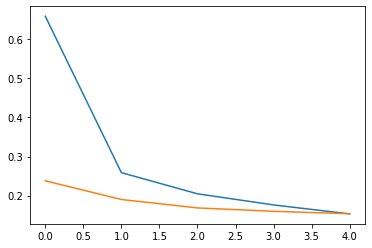

In [ ]:
plt.plot(train_loss_graph)
plt.plot(val_loss_graph)